In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import math
from scipy import stats
from scipy import integrate
import seaborn as sns

%matplotlib inline

# always useful
import numpy as np
import pandas as pd

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


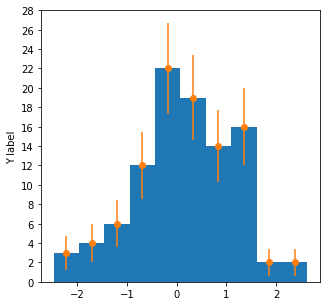

In [9]:
N = 100
mean = 0
std = 1

var = np.random.normal(mean, std, N)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Y label")
ax.yaxis.set_major_locator(MultipleLocator(2.000))
freq, bins,_ = plt.hist(var, 10)
center = (bins[:-1] + bins[1:]) / 2
err = np.sqrt(freq)

plt.errorbar(center, freq, err, fmt='o');

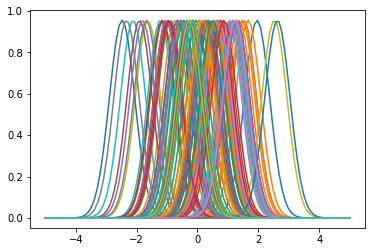

Normalized integral: 51.02729840884241
Histogram: 51.02729841420473


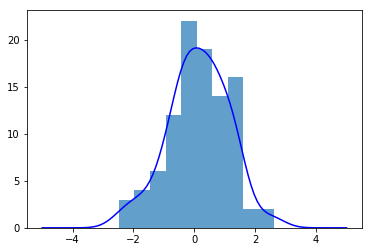

In [10]:
norms = []
for i in var:
    dominio = np.linspace(-5, 5, N)
    g = stats.norm.pdf(dominio, i, 1.06*var.std()*var.size**(-(1/5)))
    norms.append(g)
    plt.plot(dominio, g, '-')
plt.show()

bin_step = bins[1] - bins[0]

norms = np.array(norms)
somma = np.sum(norms, axis=0)
print("Normalized integral:", integrate.trapz(somma*bin_step, dominio))
print("Histogram:", np.sum(bin_step*freq))
plt.hist(var, alpha = 0.7);
plt.plot(dominio, somma*bin_step, '-b');

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

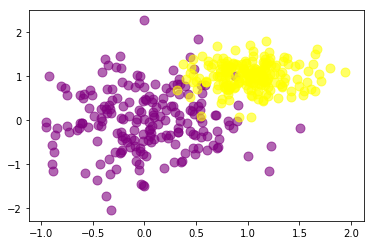

In [8]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan=2)

x1 = np.random.normal(0, 0.5, 200)
y1 = np.random.normal(0, 0.7, 200)
x2 = np.random.normal(1, 0.3, 200)
y2 = np.random.normal(1, 0.3, 200)

scatter = ax1.scatter(x=x1, y=y1, s = 80, c = 'purple', alpha = 0.6)
scatter = ax1.scatter(x=x2, y=y2, s = 80, c='yellow', alpha = 0.6)

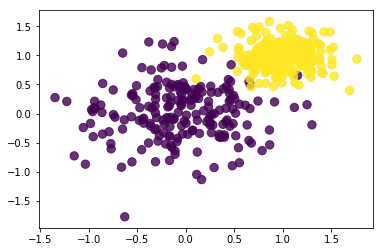

In [9]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [7]:
data = dict(np.load('residuals_261.npy').item())
df = pd.DataFrame(data)

C:\Users\Giovanni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


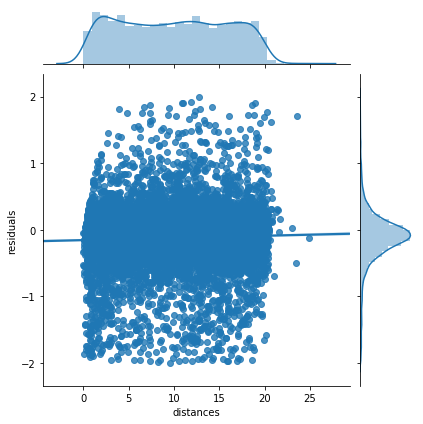

In [22]:
df = df[(np.absolute(df['residuals'].values)) < 2]
res = df['residuals']
d = df['distances']
slope, intercept, rvalue, pvalue, stderr = stats.linregress(d, res)

sns.jointplot(d, res, data = df, kind = 'reg');

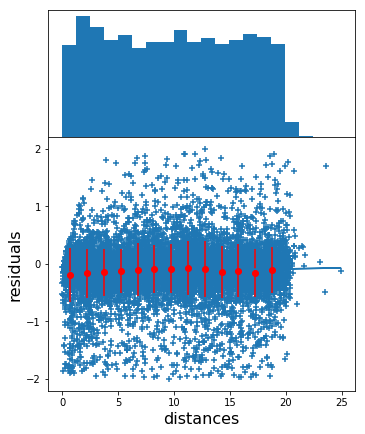

In [94]:
gridsize = (3, 2)
fig = plt.figure(figsize=(11, 7))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=2)

plt.subplots_adjust(wspace=0, hspace=0)

step = 1.5
x = np.arange(0, 20, step)
means = []
stds = []
for i in range(1, len(x)):
    temp = df[df['distances'] < x[i]]
    temp = temp[temp['distances'] > x[i-1]]
    means.append(temp['residuals'].mean(axis=0))
    stds.append(temp['residuals'].std(axis=0))

bins = []
for i in range(1, len(x)):
    bins.append(x[i] - step/2)

ax1.hist(d, 20)
ax1.yaxis.set_visible(False)

ax2.set_ylabel("residuals", fontsize = 16)
ax2.set_xlabel("distances", fontsize = 16)
ax2.yaxis.set_major_locator(MultipleLocator(1.000))
ax2.scatter(d, res, marker='+')
ax2.plot(d, d*slope+intercept);
ax2.errorbar(bins, means, yerr=stds, fmt='ro');